In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.inceptionv4 import InceptionResNetV2
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 299
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/inceptionv4")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [4]:
DEVICE = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
NUM_CLASS = 43

In [9]:
len(train_dataset)

26640

13


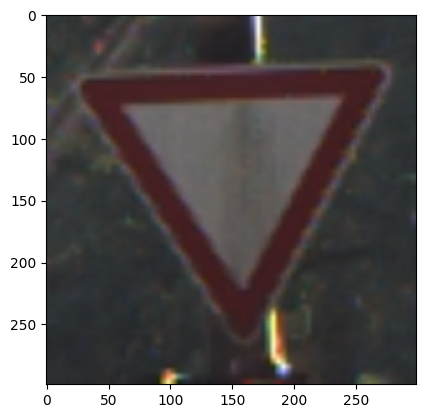

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = InceptionResNetV2(output_size=NUM_CLASS, dropout_prob=0).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                                      Param #
InceptionResNetV2                                                           --
├─Sequential: 1-1                                                           --
│    └─Conv2dNormActivation: 2-1                                            --
│    │    └─Conv2d: 3-1                                                     864
│    │    └─BatchNorm2d: 3-2                                                64
│    │    └─ReLU: 3-3                                                       --
│    └─Conv2dNormActivation: 2-2                                            --
│    │    └─Conv2d: 3-4                                                     9,216
│    │    └─BatchNorm2d: 3-5                                                64
│    │    └─ReLU: 3-6                                                       --
│    └─Conv2dNormActivation: 2-3                                            --
│    │    └─Conv2d: 3-7                    

# training

In [13]:
EPOCHS = 10
ACC_ITERS = 1

In [14]:
trainer = ClassificationTrainer(EPOCHS, DEVICE, ACC_ITERS)
trainer.recorder.increment_data_size(len(train_dataset))

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optim = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

Enable AMP: False
Training...


100%|██████████| 832/832 [04:38<00:00,  2.98it/s]


------------------------------------
Epoch 1
------------------------------------
total: 1.6424e-01 (0.00%)


100%|██████████| 832/832 [05:30<00:00,  2.51it/s]


------------------------------------
Epoch 2
------------------------------------
total: 8.0836e-02 (-51.00%)


100%|██████████| 832/832 [06:23<00:00,  2.17it/s]


------------------------------------
Epoch 3
------------------------------------
total: 3.8480e-02 (-52.00%)


100%|██████████| 832/832 [06:42<00:00,  2.07it/s]


------------------------------------
Epoch 4
------------------------------------
total: 1.1786e-02 (-69.00%)


100%|██████████| 832/832 [06:08<00:00,  2.25it/s]


------------------------------------
Epoch 5
------------------------------------
total: 5.7343e-03 (-51.00%)


100%|██████████| 832/832 [06:14<00:00,  2.22it/s]


------------------------------------
Epoch 6
------------------------------------
total: 4.0041e-03 (-30.00%)


100%|██████████| 832/832 [06:31<00:00,  2.13it/s]


------------------------------------
Epoch 7
------------------------------------
total: 2.9131e-03 (-27.00%)


100%|██████████| 832/832 [06:28<00:00,  2.14it/s]


------------------------------------
Epoch 8
------------------------------------
total: 2.1371e-03 (-27.00%)


100%|██████████| 832/832 [06:15<00:00,  2.21it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.7739e-03 (-17.00%)


100%|██████████| 832/832 [05:43<00:00,  2.42it/s]

------------------------------------
Epoch 10
------------------------------------
total: 1.5530e-03 (-12.00%)


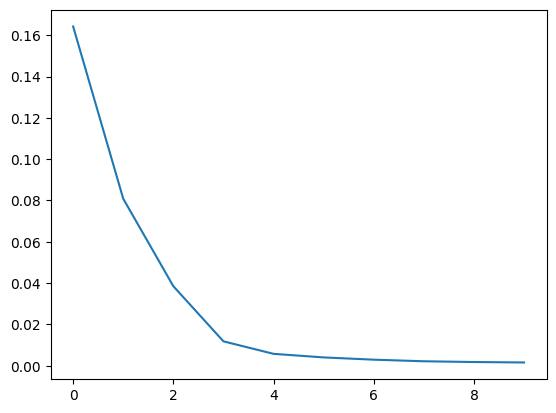

In [17]:
plt.plot(training_loss)

# inference

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [19]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 395/395 [01:00<00:00,  6.58it/s]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(NUM_CLASS), per_class_acc)

0         : 0.65
1         : 0.9208333333333333
2         : 0.7146666666666667
3         : 0.9688888888888889
4         : 0.8833333333333333
5         : 0.9587301587301588
6         : 0.66
7         : 0.9755555555555555
8         : 0.9311111111111111
9         : 0.9833333333333333
10        : 0.9984848484848485
11        : 0.9952380952380953
12        : 0.8971014492753623
13        : 0.9902777777777778
14        : 0.9777777777777777
15        : 0.9857142857142858
16        : 0.9733333333333334
17        : 0.9138888888888889
18        : 0.7512820512820513
19        : 0.05
20        : 0.45555555555555555
21        : 0.6444444444444445
22        : 0.75
23        : 0.9333333333333333
24        : 0.6777777777777778
25        : 0.7666666666666667
26        : 0.6611111111111111
27        : 0.5166666666666667
28        : 1.0
29        : 0.9333333333333333
30        : 0.5533333333333333
31        : 0.9074074074074074
32        : 0.7666666666666667
33        : 0.3142857142857143
34        : 0.99

In [24]:
per_class_acc.mean()

np.float64(0.7850052944097432)

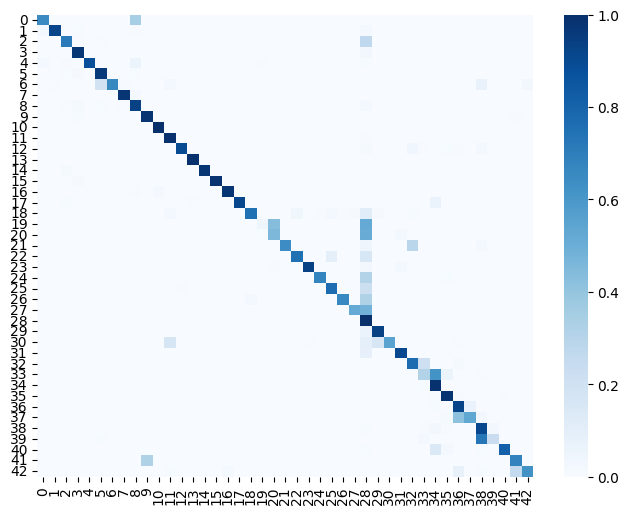

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(NUM_CLASS),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / f'inception-resnet-v2.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
get_file_size(model_path)

'137.14MiB'

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>